# Identify Customer Segments
After generating the aggregated insights from 23 million rows of AppleHealthKit data, here I will apply unsupervised learning techniques to identify segments of the population (Ongo user) that shared the AppleHealthKit data. Clusters in this segment (who shared AppleHealthKit data) will help us to understand their behavioral patterns and in turn help Ongo make more directed campaigning towards them to retain them as Ongo customers.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from termcolor import colored

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('df_concat_total.csv', index_col='easy_id')
df.head(2)

,userwise_city_no.,userwise_continent_no,health-bmi_counts,health-body-fat_counts,health-flights-climbed_counts,health-heart-rate_counts,health-mindfulness-duration_counts,health-sleep_counts,health-step-count_counts,health-step-distance_counts,...,0_health-flights-climbed,1_health-flights-climbed,health-flights-climbed_Total.3,Total_Morning_activity,Total_Night_activity,Normal_Hour_activity,Avg_Morning_activity,Avg_Night_activity,Avg_Hour_activity,owner
easy_id,,,,,,,,,,,,,,,,,,,,,
0,2,1,71.0,71.0,101.0,354239.0,246.0,5021.0,57563.0,287021.0,...,1.229508,1.400000,2.629508,64438.0,86740.0,553466.0,50.074889,51.793902,50.412481,f9946d46-0b26-444c-bf9f-d6322c0c0ce7
1,1,1,NaN,NaN,1502.0,1351.0,NaN,14.0,11711.0,11642.0,...,1.868327,2.169312,4.037640,1712.0,10612.0,13897.0,134.558779,174.567047,178.612546,72664307-6d6c-46bc-ac90-6c79f223ef8e


## 1. Preprocessing

In [3]:
# Remove duplicate columns
duplicated_feat = []
for i in range(0, len(df.columns)):
    col_1 = df.columns[i]
    for col_2 in df.columns[i + 1:]:
        # if the features are duplicated
        if df[col_1].equals(df[col_2]):
            # print them
            # print(col_1)
            # print(col_2)
            # print()
            duplicated_feat.append(col_2)

df1 = df.drop(columns=duplicated_feat)
print(
    f'No. of columns before removing duplicate features {df.shape[1]}, After removing duplicate features {df1.shape[1]}')

No. of columns before removing duplicate features 105, After removing duplicate features 105


In [4]:
# Removing any features that has more than 10% missing values
cols_2_drop = df.columns[df.isna().mean() > .1]
df1 = df.drop(columns=cols_2_drop)
df1 = df1.fillna(0)

# Need to label the easy_ids with real owner for combining with aggregated datasets from other sources
dicti = {}
for i in df1.index:
    dicti[i] = df1.loc[i, 'owner']
# dicti
df1 = df1.drop(columns=['owner'])

Here I will be mostly imputing it by 0, in most cases data not available. For example people using iPhone wont have heart rate. For them, 0 will represent missing values and this is a fair imputation w.r.t tree based models, which I could confirm at the end by checking the distribution.

In [5]:
df1.describe()

,userwise_city_no.,userwise_continent_no,health-flights-climbed_counts,health-step-count_counts,health-step-distance_counts,userwise_total_activities,Userwise No of devices synced,Total_activity_weekday,Total_activity_weekend,weekend_mean,...,health-step-count_Total.3,0_health-flights-climbed,1_health-flights-climbed,health-flights-climbed_Total.3,Total_Morning_activity,Total_Night_activity,Normal_Hour_activity,Avg_Morning_activity,Avg_Night_activity,Avg_Hour_activity
count,228.000000,228.000000,228.000000,228.000000,228.000000,2.280000e+02,228.000000,228.000000,228.000000,228.000000,...,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,1.298246,1.057018,961.587719,25532.447368,37470.592105,1.035191e+05,16.364035,72657.894737,30861.254386,0.284441,...,287.141512,1.834811,2.207508,4.042319,16888.188596,30257.864035,56373.096491,213.609686,108.763394,124.518044
std,0.838814,0.298740,820.088110,38442.091864,58508.065711,1.365216e+05,7.290929,94334.741311,45664.578109,0.071073,...,236.911451,1.405448,2.934794,4.242166,38494.828523,48362.871181,77689.013990,734.965298,107.915165,141.273257
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,328.000000,5650.750000,5632.750000,1.439225e+04,11.000000,10306.750000,4077.750000,0.250433,...,126.899401,1.205220,1.223109,2.450679,1649.750000,4011.750000,7710.250000,56.884653,59.164910,63.401378
50%,1.000000,1.000000,768.500000,14289.000000,14361.500000,6.517200e+04,15.000000,45842.500000,16899.000000,0.281052,...,250.995733,1.397559,1.450763,2.945328,5604.000000,14440.000000,33838.500000,82.707032,79.886551,87.021750
75%,1.000000,1.000000,1337.750000,30195.500000,45027.500000,1.388682e+05,21.000000,98886.250000,41657.000000,0.318239,...,394.861686,2.054517,2.176984,4.191924,18055.250000,40414.500000,76100.250000,147.567856,120.666910,143.100522
max,10.000000,4.000000,4339.000000,381972.000000,438530.000000,1.111248e+06,39.000000,814760.000000,382838.000000,0.551518,...,2459.418046,13.271038,34.132435,47.403473,465918.000000,522924.000000,553466.000000,9930.009572,1270.324426,1542.452804


Scale of the features are highly varying, we need to scale our data

### Feature Scaling

In [6]:
# Apply feature scaling to the imputed data
scaler = StandardScaler()
df1_filled_scaled = pd.DataFrame(scaler.fit_transform(df1),
                                 index=df1.index, columns=df1.columns)

## 2. Dimensionality Reduction
* Too many columns, we can perform dimensionality reduction(PCA) and still extract the most important information 
1. sklearn's principal component analysis will be used to find vectors that explain maximum variance in the data. atfirst PCA will be calculated, and all the components will be considered. Variance explained by each principle component and as well as cumulative variance explained would be considered.
2. Next, a set number of components will be picked.

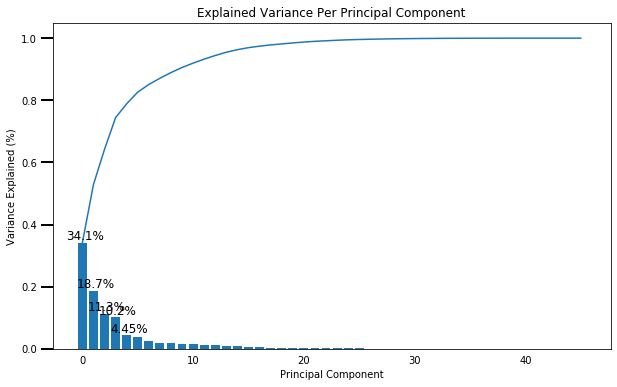

In [7]:
pca_46 = PCA(df1_filled_scaled.shape[1])
df1_filled_scaled_ = pca_46.fit_transform(df1_filled_scaled)

# Investigate the variance accounted for by each principal component.
# Define a function to visualize the variance explained by each principal component


def scree_plot(pca):
    """
    Creates a scree plot associated with the principal components.
    """
    n_comps = len(pca.explained_variance_ratio_)
    index = np.arange(n_comps)
    values = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cum_values = np.cumsum(values)
    ax.bar(index, values)
    ax.plot(index, cum_values)
    for i in range(5):
        ax.annotate(r"%s%%" % (
            (str(values[i]*100)[:4])), (index[i]+0.2, values[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


# PCA for the entire dataset # 203 PCs
scree_plot(pca_46)

**First 5 components are explaining almost 79% of the variance in the data**

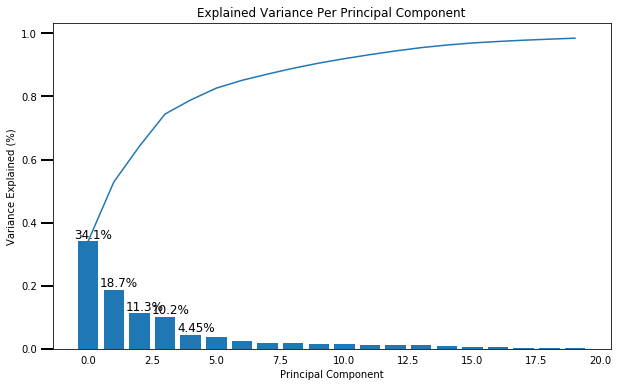

In [8]:
# Re-apply PCA to the data while selecting for number of components to retain
pca_20 = PCA(20)
df1_filled_scaled_20 = pca_20.fit_transform(df1_filled_scaled)
# PCA for the first 20 PCs
scree_plot(pca_20)

In [9]:
pca_20.explained_variance_ratio_.sum()

0.9847192662157087

**Inference**
* There are 46 components, I will retain 20 components that explains over 98% of the variance, which is great

### Interpret Principal Components
* Important as it is not as intuitive as feature importance
* Generally PCA component 1 explains the highest variance, followed by second and so on. So we can check first few principle component to see if any pattern emerges

In [10]:
# Create a dataframe to show each weight to their corresponding feature name
def pca_result(pca, df):
    """
    Create a dataframe df_comp to show weights to their corresponding features of each component/dimension.
    """
    dimensions = [f'Dimension {i}' for i in range(1, len(pca.components_) + 1)]
    df_comp = pd.DataFrame(np.round(pca.components_, 4))
    df_comp.columns = list(df.columns)
    df_comp.index = dimensions

    # Add variance ratio explained by each component/dimension
    variance_ratios = pca.explained_variance_ratio_.reshape(
        len(pca.components_), 1)
    df_variance = pd.DataFrame(np.round(variance_ratios, 4))
    df_variance.columns = ['Explained Variance']
    df_variance.index = dimensions
    df_comp = pd.concat([df_variance, df_comp], axis=1)
    return df_comp


# convert PCs to dataframes
df1_filled_comp = pca_result(pca_20, df1_filled_scaled)
df1_filled_comp.head()

,Explained Variance,userwise_city_no.,userwise_continent_no,health-flights-climbed_counts,health-step-count_counts,health-step-distance_counts,userwise_total_activities,Userwise No of devices synced,Total_activity_weekday,Total_activity_weekend,...,health-step-count_Total.3,0_health-flights-climbed,1_health-flights-climbed,health-flights-climbed_Total.3,Total_Morning_activity,Total_Night_activity,Normal_Hour_activity,Avg_Morning_activity,Avg_Night_activity,Avg_Hour_activity
Dimension 1,0.3414,0.0342,0.0394,0.0474,-0.0626,-0.0771,-0.0383,0.0207,-0.0361,-0.0399,...,0.1862,0.1892,0.1815,0.1883,0.0000,-0.0351,-0.0455,0.0793,0.1087,0.1408
Dimension 2,0.1872,0.0252,0.0061,0.1360,0.2462,0.2458,0.2875,0.2290,0.2832,0.2746,...,-0.1599,0.0967,0.1180,0.1137,0.2054,0.2377,0.2555,-0.0260,-0.0404,-0.0911
Dimension 3,0.1135,0.0581,0.0688,-0.1070,-0.0834,-0.0962,-0.0829,0.0122,-0.0742,-0.0946,...,-0.1183,-0.1836,-0.1497,-0.1644,-0.0625,-0.0669,-0.0730,0.0820,0.0041,0.0312
Dimension 4,0.1021,0.0229,0.0051,-0.0356,0.1918,0.2272,0.2092,0.1343,0.2012,0.2098,...,0.1536,-0.1570,-0.2062,-0.1947,0.1396,0.1830,0.1846,0.0824,-0.0146,0.1180
Dimension 5,0.0445,0.5828,0.5301,-0.0343,-0.0414,-0.0087,-0.0410,0.0962,-0.0673,0.0164,...,-0.0375,-0.0045,-0.0323,-0.0239,-0.0891,0.0086,-0.0332,0.0024,-0.0530,-0.0470


### Exploring top principle components

In [11]:
def investigate_PC(pca, component, feature_names):
    # code inspired by helper_functions.py in PCA lesson
    '''
    Prints association of a feature to the weights of its components
    INPUT: pca: PCA object, compnent: which component is to be investigated (0 indexed),
            feature_names: the corresponding feature names to PCA
    OUTPUT: None
    '''
    num_out = 10
    if(component <= len(pca.components_)):
        pca_feature_map = pd.DataFrame({'weight': pca.components_[component],
                                        'name': feature_names})
        pca_feature_map = pca_feature_map.sort_values(
            by='weight', ascending=False)
        print('Principal Component {}\n---------------\n'.format(component+1))
        print('TOP {0} PRINCIPAL COMPONENTS \n {1}'.format(
            num_out, pca_feature_map.iloc[:num_out, :]))
        print('\n BOTTOM {0} PRINCIPAL COMPONENTS \n {1}'.format(
            num_out, pca_feature_map.iloc[-num_out:, :]))
    else:
        print('Error in selecting component')


# First PC
investigate_PC(pca_20, 0, df1_filled_scaled.columns)

Principal Component 1
---------------

TOP 10 PRINCIPAL COMPONENTS 
       weight                            name
32  0.215767          1_health-step-distance
33  0.211122    health-step-distance_Total.3
18  0.207873      apple_health-step-distance
21  0.198199    health-step-distance_Total.2
19  0.198074     garmin_health-step-distance
20  0.194454       nike_health-step-distance
31  0.193677          0_health-step-distance
13  0.190084    health-flights-climbed_Total
37  0.189225        0_health-flights-climbed
39  0.188268  health-flights-climbed_Total.3

 BOTTOM 10 PRINCIPAL COMPONENTS 
       weight                         name
10  0.019827                  weekend_std
9   0.006158                 weekend_mean
40  0.000030       Total_Morning_activity
41 -0.035061         Total_Night_activity
7  -0.036100       Total_activity_weekday
5  -0.038298    userwise_total_activities
8  -0.039923       Total_activity_weekend
42 -0.045489         Normal_Hour_activity
3  -0.062587     health

In [12]:
# Second PC
investigate_PC(pca_20, 1, df1_filled_scaled.columns)

Principal Component 2
---------------

TOP 10 PRINCIPAL COMPONENTS 
       weight                           name
5   0.287532      userwise_total_activities
7   0.283182         Total_activity_weekday
8   0.274622         Total_activity_weekend
42  0.255535           Normal_Hour_activity
3   0.246232       health-step-count_counts
4   0.245765    health-step-distance_counts
41  0.237710           Total_Night_activity
6   0.229023  Userwise No of devices synced
40  0.205372         Total_Morning_activity
2   0.135960  health-flights-climbed_counts

 BOTTOM 10 PRINCIPAL COMPONENTS 
       weight                       name
15 -0.107901  health-step-count_Total.1
22 -0.129342    Other_health-step-count
25 -0.130184     nike_health-step-count
35 -0.138626        1_health-step-count
26 -0.143415  health-step-count_Total.2
12 -0.150317    health-step-count_Total
24 -0.155066   garmin_health-step-count
36 -0.159856  health-step-count_Total.3
23 -0.162501    apple_health-step-count
34 -0.169165

In [13]:
# 3rd PC
investigate_PC(pca_20, 3, df1_filled_scaled.columns)

Principal Component 4
---------------

TOP 10 PRINCIPAL COMPONENTS 
       weight                         name
4   0.227214  health-step-distance_counts
22  0.225010      Other_health-step-count
25  0.222661       nike_health-step-count
26  0.217454    health-step-count_Total.2
8   0.209847       Total_activity_weekend
5   0.209211    userwise_total_activities
7   0.201191       Total_activity_weekday
24  0.193474     garmin_health-step-count
3   0.191780     health-step-count_counts
42  0.184569         Normal_Hour_activity

 BOTTOM 10 PRINCIPAL COMPONENTS 
       weight                            name
2  -0.035629   health-flights-climbed_counts
16 -0.151806  health-flights-climbed_Total.1
37 -0.157042        0_health-flights-climbed
30 -0.174527  health-flights-climbed_Total.2
28 -0.181493   garmin_health-flights-climbed
13 -0.181761    health-flights-climbed_Total
27 -0.188682    apple_health-flights-climbed
39 -0.194700  health-flights-climbed_Total.3
38 -0.206228        1_health-

**From first 3 PC, the features responisble for highest variance, need to be given importance**

In [14]:
# compute the average within-cluster distances f
kmeans_2 = (KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300,
                   random_state=0, algorithm='elkan'))
kmeans_2 = kmeans_2.fit(df1_filled_scaled_20)
kmeans_2.score(df1_filled_scaled_20)

-7881.4279211451885

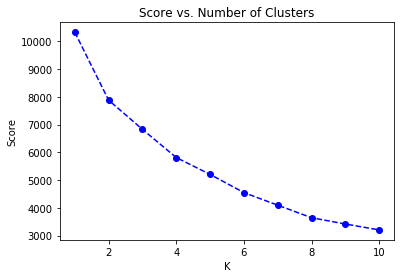

In [15]:
# Investigate the change in within-cluster distance across number of clusters.
def elbow_method(n_cluster, data):
    """
    Plot the kmeans scores of data across number of clusters. 
    Input: n_cluster - number of clusters 
    """
    centers = list(range(1, n_cluster+1))
    scores = []
    for center in centers:
        kmeans = KMeans(center, init='k-means++', algorithm='elkan')
        model = kmeans.fit(data)
        score = np.absolute(model.score(data))
        scores.append(score)

    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.title('Score vs. Number of Clusters')


elbow_method(10, df1_filled_scaled_20)

I decided to pick as few of a cluster (4) as I have too few of a data points (making the model less robust)

In [16]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the AppleHealthKit sharing users
kmeans = (KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300,
                 tol=0.0001,  random_state=111, algorithm='elkan'))
kmeans = kmeans.fit(df1_filled_scaled_20)
print(kmeans.score(df1_filled_scaled_20), '\n\n')

# Putting this with scaled and original aggregated data (generated from AppleHealthKit data)
df1['kmeans_pred'] = kmeans.predict(df1_filled_scaled_20)
df1_filled_scaled['kmeans_pred'] = kmeans.predict(df1_filled_scaled_20)

print(f'Value counts for each clusters:')
df1['kmeans_pred'].value_counts()

-5860.695055436086 


Value counts for each clusters:


0    118
1     98
2     11
3      1
Name: kmeans_pred, dtype: int64

Now we can use this for Supervised learning and see which features are most likely impacting clusters


* Too few observation in 2 and 3, so we should focus on binary classification between cluster 0 and 1.
* Once more people sync in their 3rd party integration, we can go for more clusters.

In [17]:
# Now if we want to make a binary classification model, we have to remove OUTLIER clusters
filt = df1['kmeans_pred'].isin([2, 3])
df_classi_unscaled = df1.drop(index=df1[filt].index)

filt = df1_filled_scaled['kmeans_pred'].isin([2, 3])
df_classi = df1_filled_scaled.drop(index=df1_filled_scaled[filt].index)
df_classi['kmeans_pred'] = df_classi['kmeans_pred']  # .map({0:0,2:1})

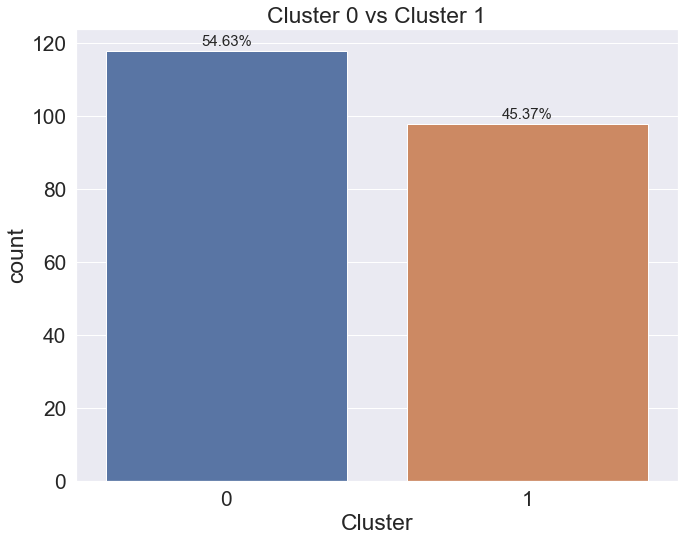

In [19]:
# Copying the scaled AppleHealthKit aggregated data with cluster information to run supervised learning
# Goal: To identify features that segregate individuals into 2 separate clusters
df = df_classi.copy()

# function for countplot
def bplot_perc(col, data, title, xlabel, ax=None, hue=None):
    sns.set(font_scale=1.9)
    sns.countplot(col, data=data, ax=ax, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 1.3,
                '{:1.2f}%'.format((height/total)*100), ha="center", size=15)
    plt.tight_layout()
    plt.show()


# plot for target variable
f, ax = plt.subplots(figsize=(10, 8))
bplot_perc(col='kmeans_pred', data=df,
           title='Cluster 0 vs Cluster 1', xlabel='Cluster', ax=ax)

Imbalance between clusters

### Deciphering relationships between numerical features w.r.t target (cluster)

In [20]:
correlated_features = df.corr()[['kmeans_pred']].sort_values(
    by='kmeans_pred', ascending=False)
correlated_features[1:11].style.background_gradient(cmap='summer_r')

,kmeans_pred
Normal_Hour_activity,0.537957
Total_activity_weekday,0.537187
userwise_total_activities,0.535485
health-step-distance_counts,0.52311
Total_activity_weekend,0.491065
health-step-count_counts,0.478507
Userwise No of devices synced,0.451168
Total_Night_activity,0.431493
Total_Morning_activity,0.266826
health-flights-climbed_counts,0.245907


**Green means, those features are more correlated with target or cluster 1, Yellow means less correlated with target or cluster 1**

## 3. Modeling

In [21]:
# importing all the required ML packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Models
logreg = LogisticRegression(
    random_state=0, solver='lbfgs', class_weight='balanced')
randomforest = RandomForestClassifier(
    random_state=0, n_estimators=100, class_weight='balanced')

# Splititng data into train and test set
X = df.drop(columns=['kmeans_pred'])
y = df['kmeans_pred']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [22]:
# Model quality prediction
model_names = ['LogisticRegression', 'RandomForest']
models = [logreg, randomforest]

# function for model quality prediction
def model_quality(models):
    for i in range(len(models)):
        print('■'*22, '\033[1m' + colored(model_names[i], 'green'), '■'*23)
        models[i].fit(X_train1, y_train1)
        accuracy_model = round(models[i].score(X_test1, y_test1) * 100, 2)
        print('accuracy :', accuracy_model, "\n")
        auc = roc_auc_score(y_test1, models[i].predict(X_test1))
        print("AUC = %2.2f" % auc)
        print(classification_report(y_test1, models[i].predict(X_test1)))
        print("\n\n")


model_quality(models)

■■■■■■■■■■■■■■■■■■■■■■ LogisticRegression ■■■■■■■■■■■■■■■■■■■■■■■
accuracy : 100.0 

AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        29

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65




■■■■■■■■■■■■■■■■■■■■■■ RandomForest ■■■■■■■■■■■■■■■■■■■■■■■
accuracy : 98.46 

AUC = 0.98
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.97      0.98        29

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65






As dataset is small we have to wait for more data to make the model more robust, but both logistic regression and random forest performs well.

One way to undersatnd we can expect this kind of performance metrics with future data is to run cross-validation (but best solution is to have more synced in AppleHealthKit data)

In [23]:
def cross_validation(X, y):
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    xyz = []
    accuracy_cv = []
    classifiers = ['Logistic Regression', 'Random Forest']
    models = [logreg, randomforest]
    for i in models:
        model = i
        cv_result = cross_val_score(model, X, y, cv=kfold, scoring="f1")
        cv_result = cv_result
        xyz.append(cv_result.mean())
        accuracy_cv.append(cv_result)
    new_models_dataframe2 = pd.DataFrame({'CV Mean': xyz}, index=classifiers)
    new_models_dataframe2.loc['avg'] = new_models_dataframe2.mean()
    return new_models_dataframe2
    return accuracy_cv


cv_comp = cross_validation(X, y)
cv_comp.columns = ['Model_F1_CVmean']
cv_comp.sort_values(by='Model_F1_CVmean', ascending=False)
#cv_comp.loc['avg'] =cv_comp.mean()
cv_comp

,Model_F1_CVmean
Logistic Regression,0.990221
Random Forest,0.965490
avg,0.977855


### Let's explore feature importance for these clusters

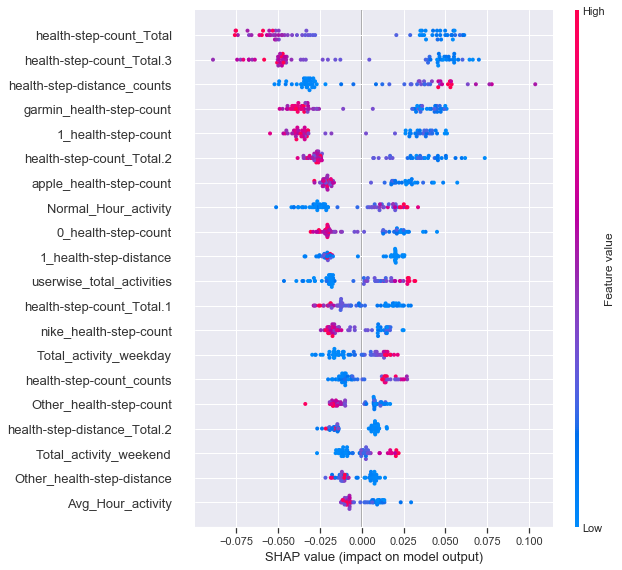

In [24]:
import shap
# Create object that will calculate shap values
explainer = shap.TreeExplainer(randomforest)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test1)
# Summary plot
shap.summary_plot(shap_values[1], X_test1)

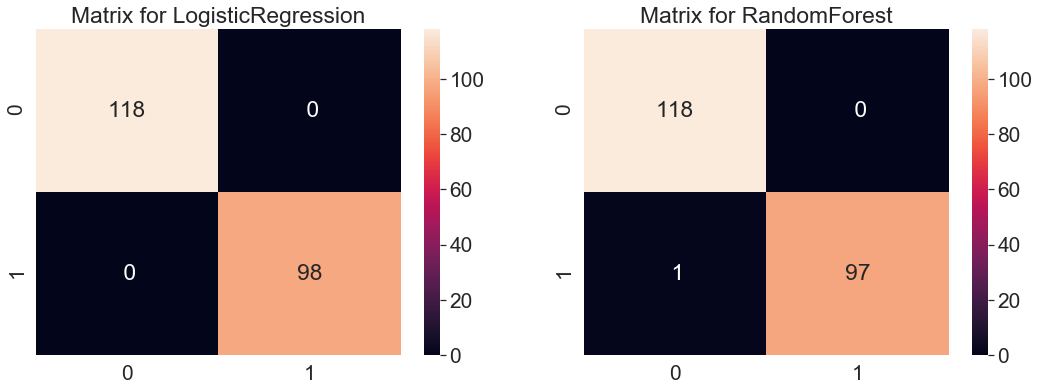

In [25]:
def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        y_pred = cross_val_predict(models[i], X, y, cv=10)
        sns.heatmap(confusion_matrix(y, y_pred),
                    ax=ax[i], annot=True, fmt='2.0f')
        ax[i].set_title('Matrix for ' + model_names[i])


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
confusion_matrix_plot(df, df['kmeans_pred'])

In [26]:
# Let's pick minimum number and intuitive features and see how model performs
cols = ['Total_activity_weekend', 'health-step-count_counts', 'Total_activity_weekday',
        'userwise_total_activities', 'Normal_Hour_activity', 'health-step-distance_counts', 'health-step-count_Total',
        'Userwise No of devices synced', 'apple_health-step-count', 'Total_Morning_activity', 'Total_Night_activity',
        'Userwise No of devices synced']

# Splititng data into train and test set
df = df_classi.copy()
X = df[cols]  # .drop(columns=['kmeans_pred'])
y = df_classi['kmeans_pred']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.3, random_state=0)

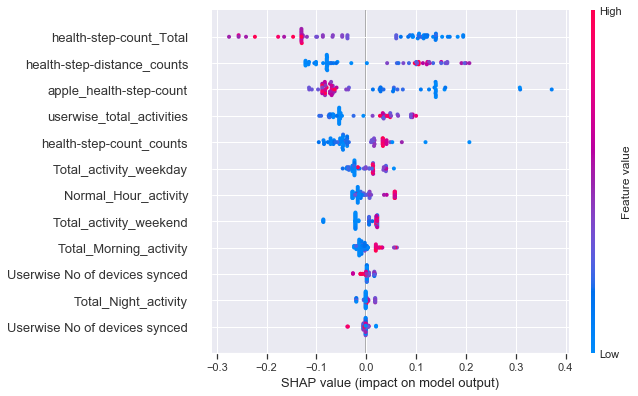

In [27]:
randomforest = RandomForestClassifier(random_state=0, class_weight='balanced')
randomforest.fit(X_train2, y_train2)
# Create object that will calculate shap values
explainer = shap.TreeExplainer(randomforest)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test2)
# Summary plot
shap.summary_plot(shap_values[1], X_test2)

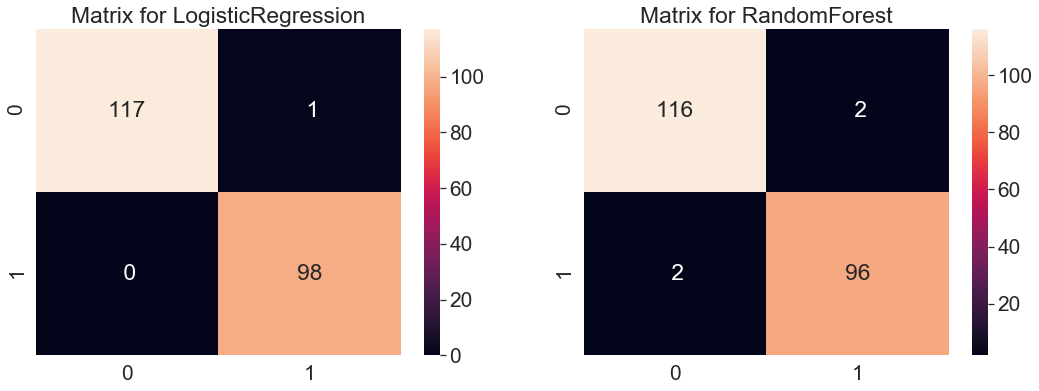

In [28]:
# Let's pick minimum and intuitive features and see how model performs
df1 = df[cols]


def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        y_pred = cross_val_predict(models[i], X, y, cv=10)
        sns.heatmap(confusion_matrix(y, y_pred),
                    ax=ax[i], annot=True, fmt='2.0f')
        ax[i].set_title('Matrix for ' + model_names[i])


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
confusion_matrix_plot(df1, df['kmeans_pred'])

These few features are extremely important for determining the clusters

### Interpretation

`health-step-count_Total`,`Total_Activity_weekday`, `Normal_Hour_Activity`, `Total_Activity_Weekend`, `Total_Night_activity` are some of the features are extremely important for putting users in a cluster.

* When a new Ongo user syncs his/her data, we should be particularly interested in these features to put that individual in a cluster

* Anyone with more activities (`health-step-count_Total`) will fall in cluster 0 and vice versa.
* Similarly people who are more active have high health-step-count_Total are GLADIATORS and less active are COUCH LOVERS

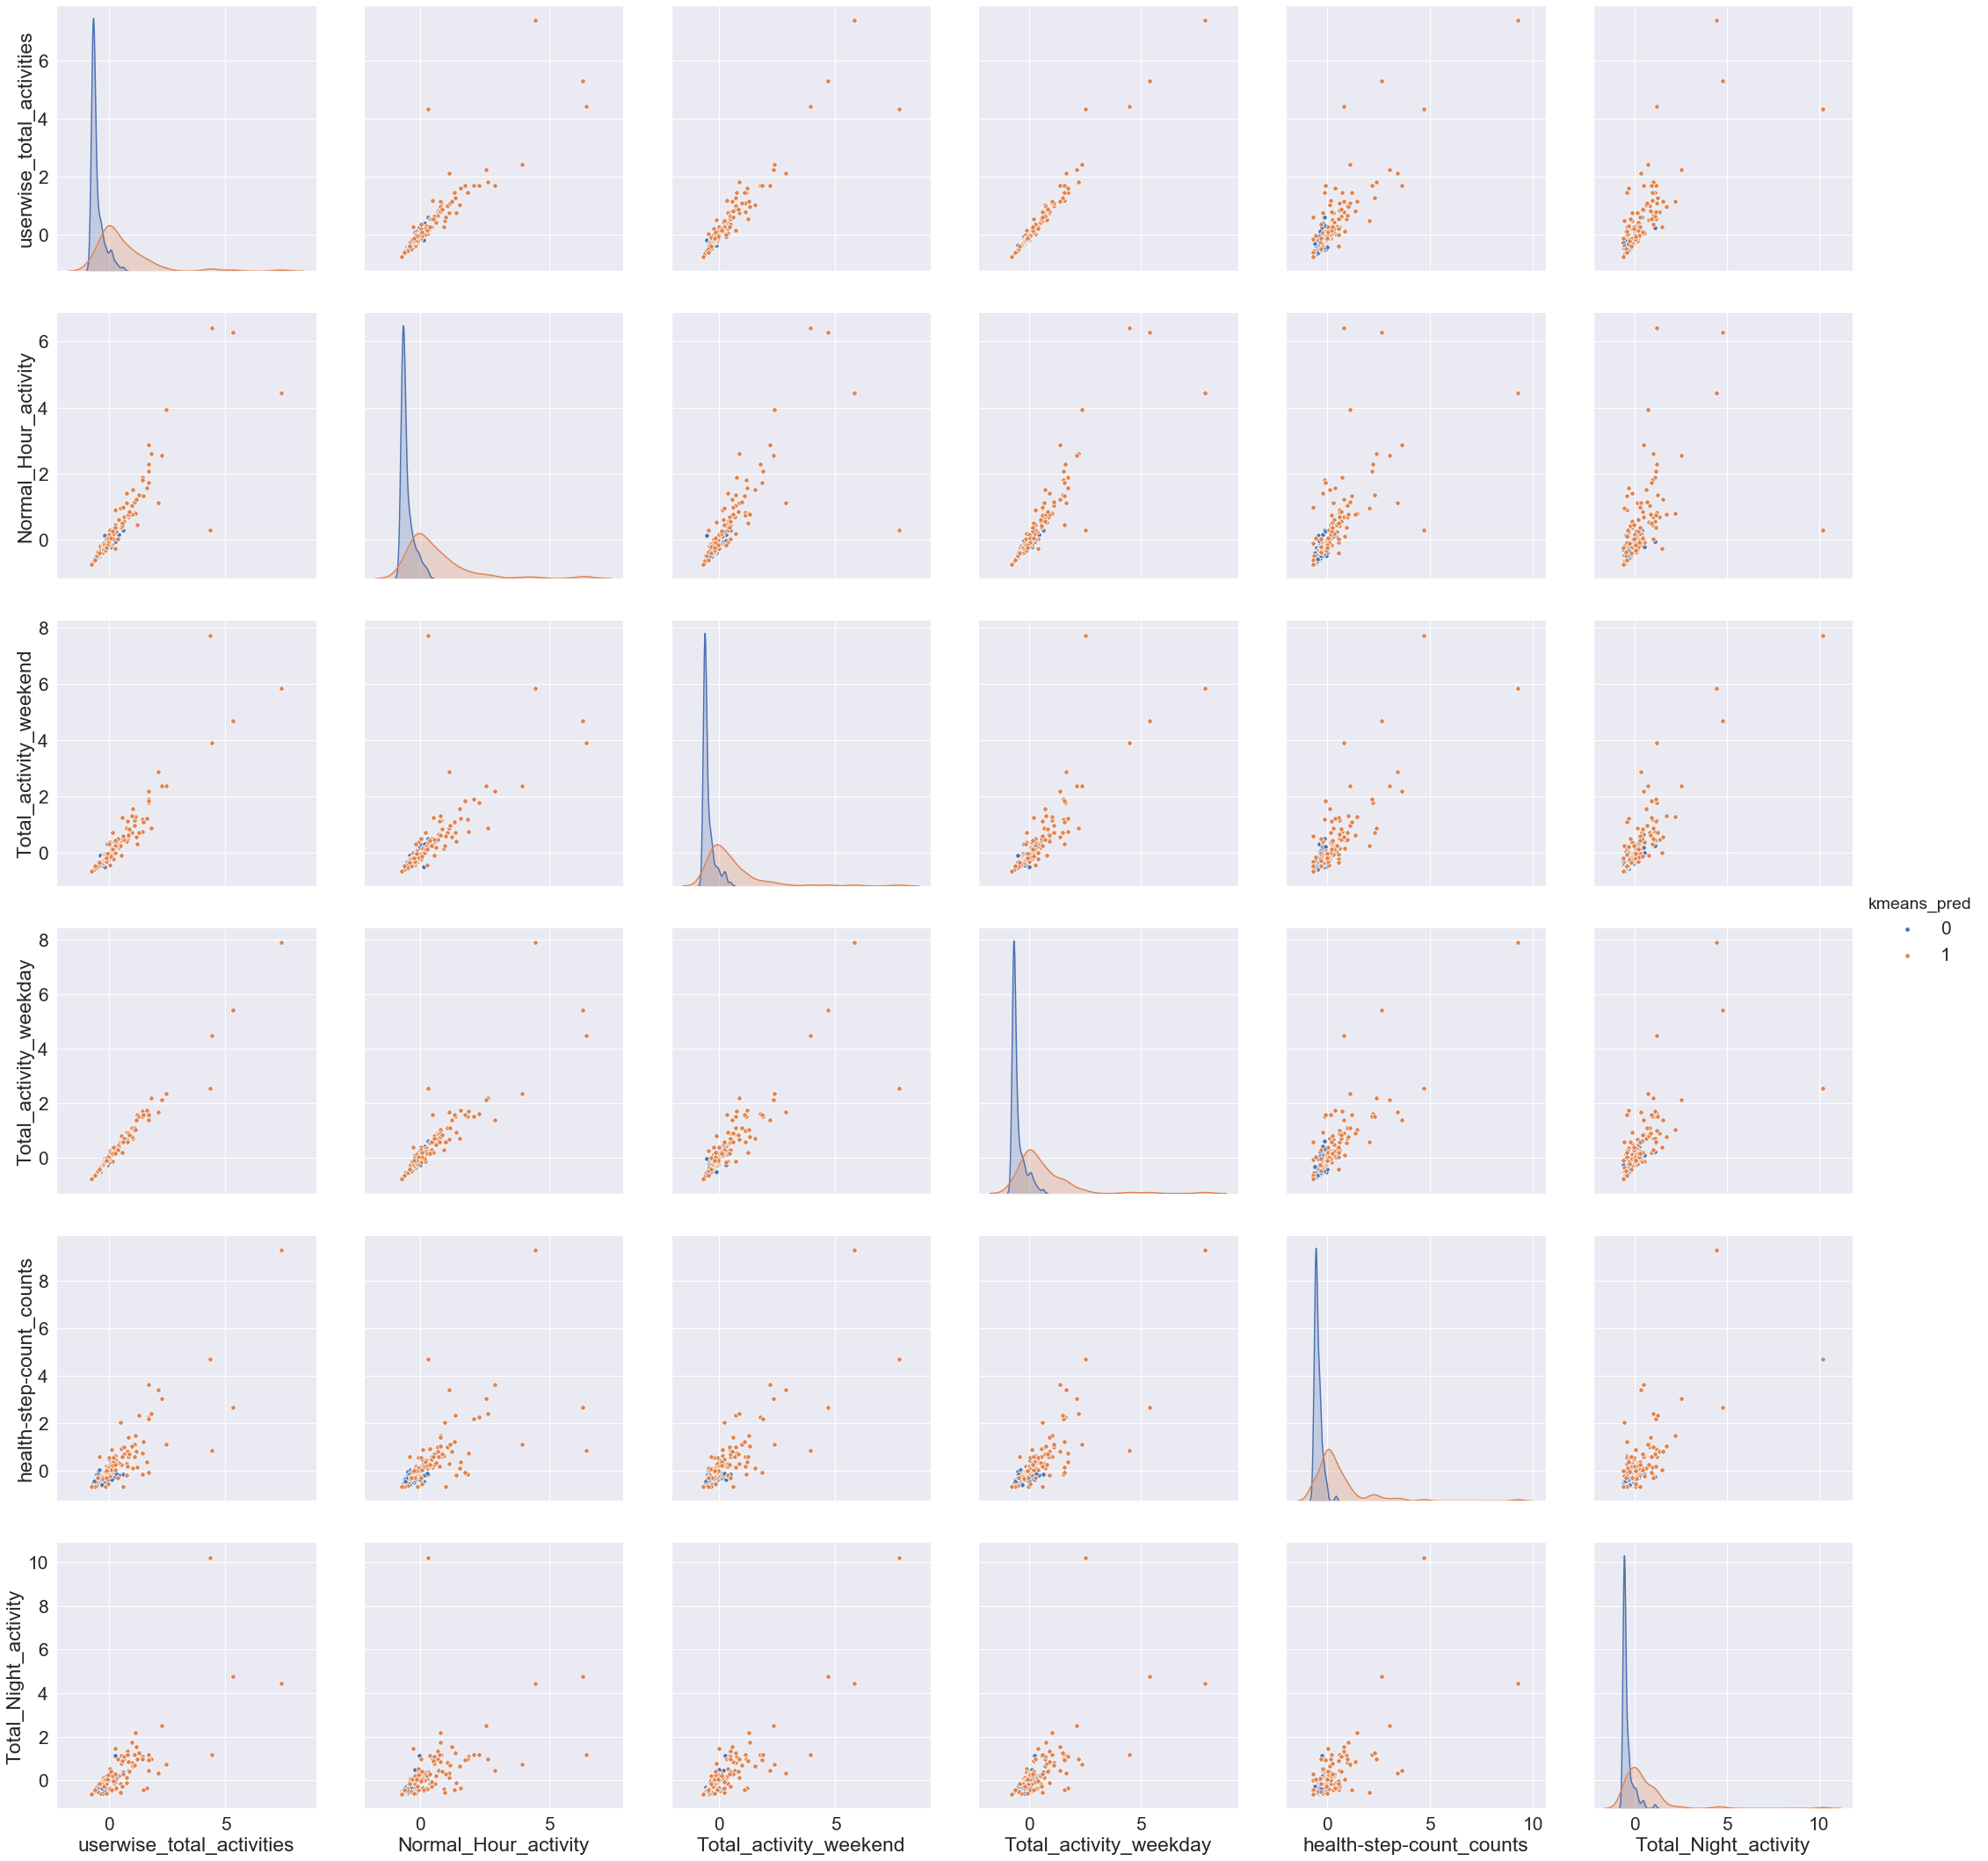

In [29]:
# Selected features
cols2 = ['userwise_total_activities', 'Normal_Hour_activity', 'Total_activity_weekend', 'Total_activity_weekday',
         'health-step-count_counts', 'Total_Night_activity']
sns.pairplot(df_classi, diag_kind='kde', vars=cols2,
             hue='kmeans_pred', plot_kws={'s': 30}, height=5.0)

We see a lot of spike near 0 for cluster 1, based on 0 based imputation, a question is am I changing distribution of these columns. Lets confirm on this

In [30]:
df = pd.read_csv('df_concat_total.csv', usecols=cols)
df.isna().sum()

health-step-count_counts         9
health-step-distance_counts      7
userwise_total_activities        0
Userwise No of devices synced    0
Total_activity_weekday           0
Total_activity_weekend           1
health-step-count_Total          9
apple_health-step-count          9
Total_Morning_activity           1
Total_Night_activity             1
Normal_Hour_activity             0
dtype: int64

These confirms most of these columns didn't have a huge amount of missing values, so imputation didn't change the distribution. 

#### Here we see how these few features can capture the hidden patterns that are used to cluster the data, this will be added with DataWorkoutRun aggregated data as well. They might have predictive features.

##### Overall, total activity, health-step-count_Total, weekday vs weekend activites are essential for clustering Ongo users who synced their AppleHealthkit data to the TRE app, and based on that we can recommend them specific programs. For example-
* So we can put people who have higher activities in weekdays in cluster 1 [based on their synced data we can recommend them to `Weekday challenge program`] and users with lower activities fall in cluster 0 [based on their synced data we can recommend them to `Weekend wellness program`]

* Similarly people who are more active have high `health-step-count_Total` are `GLADIATORS` and less active are `COUCH LOVERS`

In [31]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# step forward feature selection TO select most relevant features for a tree based model
sfs = SFS(RandomForestClassifier(n_jobs=4),
          k_features=10,
          forward=True,
          floating=False,
          verbose=0,
          scoring='roc_auc',
          n_jobs=4,
          cv=5)
sfs = sfs.fit(np.array(X_train1), y_train1)

# Selected features based on step-forward feature elimination
selected = X_train1.columns[list(sfs.k_feature_idx_)]
print('Top selected features by step forward elimination are:\n ', selected.to_list())

Top selected features by step forward elimination are:
  ['health-step-count_counts', 'userwise_total_activities', 'Total_activity_weekday', 'health-step-distance_Total.2', 'Other_health-step-count', 'apple_health-flights-climbed', 'health-flights-climbed_Total.2', 'health-step-distance_Total.3', '1_health-step-count', 'health-step-count_Total.3']


### Extract the data that would be added to DataWorkoutRun

In [32]:
df_2_add_2_DataWorkoutRun = df_classi_unscaled.loc[:, selected.to_list(
)+['kmeans_pred']]  # .map({0:0,2:1})
df_2_add_2_DataWorkoutRun['kmeans_pred'] = df_2_add_2_DataWorkoutRun['kmeans_pred']
df_2_add_2_DataWorkoutRun['owner'] = df_2_add_2_DataWorkoutRun.index.map(dicti)
df_2_add_2_DataWorkoutRun.to_csv("df_2_add_2_DataWorkoutRun.csv", index=True)

# This dataframe would be added to DataWorkoutRun after DataWorkoutRun is aggregated (Part B, notebook2)
df = pd.read_csv('df_2_add_2_DataWorkoutRun.csv')
df.head(2)

,easy_id,health-step-count_counts,userwise_total_activities,Total_activity_weekday,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner
0,0,57563.0,704644.0,495784.0,42.920799,61.258929,1.333333,3.642857,19.402514,68.203092,121.880543,1,f9946d46-0b26-444c-bf9f-d6322c0c0ce7
1,1,11711.0,26221.0,20527.0,832.082885,251.100000,1.963710,9.419592,287.813392,222.011342,461.291289,0,72664307-6d6c-46bc-ac90-6c79f223ef8e


In [33]:
###### Next: in Part B, 1.DataWorkOutRun_Cleaning_for_Aggregation_G.ipynb #######